NOT USING THIS VVV

---

In [10]:
DATA_PATH = './data'
TRAIN_DATA_PATH = f'{DATA_PATH}/train'
TASK_DATA_PATH = f'{DATA_PATH}/train'
TRAIN_FILENAME = f'{DATA_PATH}/train_gt.csv'
TASK_FILENAME = f'{DATA_PATH}/test.csv'

In [11]:
import pandas as pd
from tqdm import tqdm

df = pd.read_csv(TRAIN_FILENAME, header=None, names=['audio', 'label'])[:100]
df['audio'] = TRAIN_DATA_PATH + "/" + df['audio']

x, y = df['audio'], df['label'].to_numpy().reshape(-1, 1)

In [12]:
import librosa
import numpy as np
from transformers import ASTFeatureExtractor

feature_extractor = ASTFeatureExtractor()

def preprocess_function(audio_path):
    y, sr = librosa.load(audio_path)

    inputs = feature_extractor(y, return_tensors='np', feature_size=-1, sampling_rate=16000) # Probably not 16000
    return inputs['input_values'].reshape(1024, 128, 1)

In [13]:
x = np.stack([preprocess_function(audio) for audio in tqdm(x)])

100%|██████████| 100/100 [00:00<00:00, 206.65it/s]


In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import Model

In [15]:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv = Sequential([
      Conv2D(32, (3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2))
    ])
    self.flatten = Flatten()
    self.denses = Sequential([
      Dense(128, activation='relu'),
      Dense(1, activation='sigmoid')
    ])
    

  def call(self, x):
    x = self.conv(x)
    x = self.flatten(x)
    x = self.denses(x)
    return x

model = MyModel()

In [16]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

custom_callbacks = [
    EarlyStopping(
        monitor='f1_score', 
        min_delta=1e-5, 
        patience=5, 
        verbose=0, 
        mode='auto', 
        baseline=None, 
        restore_best_weights=False
    ),
    ModelCheckpoint(
        './cnn_save/checkpoint.keras', 
        monitor='f1_score', 
        verbose=0, 
        save_best_only=True,
        save_weights_only=False, 
        mode='auto', 
        save_freq='epoch'
    )
]

model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy', tf.keras.metrics.F1Score()]
)

In [17]:
hist = model.fit(x, y, epochs=10, callbacks=custom_callbacks)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5721 - f1_score: 0.3892 - loss: 57.7684   
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - accuracy: 0.5989 - f1_score: 0.5412 - loss: 18.8755
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 533ms/step - accuracy: 0.6579 - f1_score: 0.4962 - loss: 14.0585
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - accuracy: 0.7707 - f1_score: 0.4962 - loss: 7.9100
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step - accuracy: 0.4696 - f1_score: 0.4735 - loss: 4.2462
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step - accuracy: 0.7045 - f1_score: 0.4832 - loss: 1.0658
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 531ms/step - accuracy: 0.8311 - f1_score: 0.4622 - loss: 0.7382


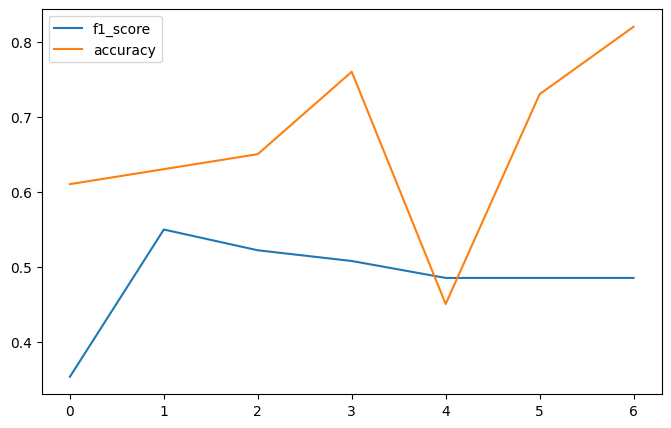

In [18]:
pd.DataFrame(hist.history)[['f1_score', 'accuracy']].plot(figsize=(8,5))
plt.show()